## This notebook walks through the basics of generating synthetic choice data and fitting the model to that data to recover the paramaters that generated it

Fitting these models to data to choice data alone can be computational expensive. We fit the model below using 44 cpus.

`using` is the julia version of python's `import`, i.e. in incorporates the exported functions of a module into the current namespace. `Distributed` is a julia module for performing parallel computing. `addprocs()` adds some workers, which can be called by a main process if there are calls to do things in parallel. `PulseInputDDM` parallelizes the computation of the log-likelhood across trials.

In [1]:
using Distributed
addprocs(28);

### Fitting a choice model.

when `using` is called after workers have been made, i.e. above, then those modules are available on all the workers (i.e. any function called from those modules will be able to be executed on any worker)

In [2]:
@everywhere using PulseInputDDM, Flatten

### Generate some data

Create an instance of the `θchoice` [composite type](https://docs.julialang.org/en/v1/manual/types/#Composite-Types) which contains the 9 parameters of a choice DDM model. 

In [3]:
using PyPlot

In [4]:
θ_syn = θchoice(θz=θz(σ2_i = 1., B = 13., λ = -0.5, σ2_a = 10., σ2_s = 1.0,
    ϕ = 0.4, τ_ϕ = 0.02), bias=0.1, lapse=0.1);

Generate 8K trials of the synthetic data using those parameters. change `rng` to get a different set with the same parameters. `dt` specifies the temporal binning of the data. `1e-2` has worked well.

In [5]:
_, data = synthetic_data(;θ=θ_syn, ntrials=8_000, rng=2, dt=1e-2);

Create an instance of the `choiceDDM` composite type which contains the parameters and the data of a choice DDM model. 

In [6]:
model_gen = choiceDDM(θ=θ_syn)


choiceDDM{θchoice{θz{Float64}, Float64, Float64}}
  θ: θchoice{θz{Float64}, Float64, Float64}
  n: Int64 53
  cross: Bool false
  fit: Array{Bool}((9,)) Bool[1, 1, 1, 1, 1, 1, 1, 1, 1]
  lb: Array{Float64}((9,)) [0.0, 4.0, -5.0, 0.0, 0.0, 0.01, 0.005, -5.0, 0.0]
  ub: Array{Float64}((9,)) [30.0, 30.0, 5.0, 100.0, 2.5, 1.2, 1.0, 5.0, 1.0]


Compute the loglikelihood of the model under the generative parameters

In [7]:
loglikelihood(model_gen, data)

-2969.982344856519

random initial state

In [8]:
x0 = vcat([0.1, 15., -0.1, 20., 0.5, 0.2, 0.008], [0.,0.01]);

use `Flatten.reconstruct` to place the intial state into the `θchoice()` type, with each variable going into the right place

In [9]:
θ = Flatten.reconstruct(θchoice(), x0)

θchoice{θz{Float64}, Float64, Float64}
  θz: θz{Float64}
  bias: Float64 0.0
  lapse: Float64 0.01


In [10]:
model = choiceDDM(θ=θ);

Compute the loglikelihood of the model under the initial parameters

In [11]:
loglikelihood(model, data)

-3473.4312908567326

Create an instance of the `choiceoptions` composite type, using `lb`, `ub`, and `fit`. `choiceoptions` specifies which parameters to fit, and the lower and upper bounds of the optimization.

In [12]:
model.lb = vcat([0., 2.,  -5., 0.,   0.,  0., 0.005, -5.0, 0.0]);
model.ub = [30., 100., 5., 200., 10., 1.2,  1., 5.0, 1.0];
model.fit = trues(9);

Define bounds for each parameter for the optimization. Some of these are strict (i.e. variance > 0) and some are not (B < 100 seems reasonable, but B could of course be larger then 100.)

### Optimize the model, using the options to define details of the optimization

In [13]:
model, output = fit(model, data)

Fminbox
-------
Initial mu = 0.160987

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.160987

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     3.471460e+03     5.400220e+04
 * time: 0.016784191131591797
    10     2.966520e+03     1.878303e+03
 * time: 262.582316160202
    20     2.959900e+03     2.580483e+02
 * time: 474.0698161125183
    30     2.959601e+03     2.769489e+01
 * time: 685.8496150970459
    40     2.959527e+03     3.386857e-01
 * time: 897.1697351932526
    50     2.959518e+03     6.917299e-01
 * time: 1108.814162015915

Exiting inner optimizer with x = [18.637110351632536, 14.877849866534907, -0.6833150330350558, 21.233555359853348, 1.0816049664619185, 0.5476649751158597, 0.01770671919035834, 0.16108836469039572, 0.0700446111568121]
Current distance to box: 0.0127067
Decreasing barrier term μ.

Fminbox iteration 2
-------------------
Calling inner optimizer with mu = 0.000160987

(numbers belo

(choiceDDM{θchoice{θz{Float64}, Float64, Float64}}
  θ: θchoice{θz{Float64}, Float64, Float64}
  n: Int64 53
  cross: Bool false
  fit: Array{Bool}((9,)) Bool[1, 1, 1, 1, 1, 1, 1, 1, 1]
  lb: Array{Float64}((9,)) [0.0, 2.0, -5.0, 0.0, 0.0, 0.0, 0.005, -5.0, 0.0]
  ub: Array{Float64}((9,)) [30.0, 100.0, 5.0, 200.0, 10.0, 1.2, 1.0, 5.0, 1.0]
,  * Status: success

 * Candidate solution
    Final objective value:     2.962903e+03

 * Found with
    Algorithm:     Fminbox with BFGS

 * Convergence measures
    |x - x'|               = 3.61e-05 ≰ 1.0e-10
    |x - x'|/|x'|          = 1.09e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 1.0e-09
    |g(x)|                 = 2.99e-02 ≰ 1.0e-03

 * Work counters
    Seconds run:   2427  (vs limit 170000)
    Iterations:    4
    f(x) calls:    155
    ∇f(x) calls:   89
)

Compute the likelihood of the optimized model

In [14]:
loglikelihood(model, data)

-2962.9032243243228

Compute the gradient of the model after optimization, to ensure we are near the minimum of the loglikelihood

In [15]:
gradient(model, data)

9-element Vector{Float64}:
 -0.0003225196474827899
  0.0016842712712451524
  0.013110035643336015
 -0.0003110470146129446
 -0.007397937387439324
 -0.004261251450824233
  0.0826579967890666
  0.00508310540347362
 -0.02991409246407528

Compute the Hessian of the model, to compute confidence bounds around the ML parameters

In [16]:
H = Hessian(model, data)
CI, HPSD = CIs(H);

┌ Warning: Hessian is not positive definite. Approximated by closest PSD matrix.
│             ||ϵ||/||H|| is 0.000767563435422035
└ @ PulseInputDDM /usr2/faculty/bddepasq/PulseInputDDM.jl/src/utils.jl:15


Check the eigenvalues of the hessian, to ensure that it is positive semidefinite

In [17]:
using LinearAlgebra
eigvals(H)

9-element Vector{Float64}:
     -0.0001400212637220852
      0.0017667051246032053
      0.019310623331291212
      7.430218163535351
     17.01474741244413
     41.40719220294924
     59.368472879440496
  15808.371202124526
 792478.4490740973

In [18]:
xf = collect(Flatten.flatten(model.θ));

In [19]:
xgen = collect(Flatten.flatten(θ_syn));

Check that the solution is within the confidence intervals

In [20]:
(xf - CI) .< xgen, (xf + CI) .> xgen

(Bool[1, 1, 1, 1, 1, 1, 1, 1, 1], Bool[1, 1, 1, 1, 1, 1, 1, 1, 1])

Get the step-by-step values of the optimization and plot them

In [21]:
trace = hcat(map(x-> x.metadata["x"], output.trace)...);

KeyError: KeyError: key "x" not found

In [22]:
using PyPlot

In [23]:
num_rows, num_cols = 3,3
fig, ax = subplots(num_rows, num_cols, figsize=(9,9))
name = ["σ2_i", "B", "λ", "σ2_a", "σ2_s", "ϕ", "τ_ϕ", "bias", "lapse"]

for i in 1:9
                  
    ax[i].plot(trace[i,:])
    ax[i].plot(xgen[i] * ones(size(trace,2)))
    ax[i].set_title(name[i])
    
    ax[i].errorbar(size(trace, 2), xf[i], yerr=CI[i], fmt="o",
        capsize=6)
end

tight_layout() 
display(gcf())

UndefVarError: UndefVarError: `trace` not defined

Compute the LL over the optimization domain, for plotting

In [24]:
@everywhere ℓℓ(x) = -PulseInputDDM.loglikelihood(x, model, data)

In [25]:
lb,ub = model.lb, model.ub

([0.0, 2.0, -5.0, 0.0, 0.0, 0.0, 0.005, -5.0, 0.0], [30.0, 100.0, 5.0, 200.0, 10.0, 1.2, 1.0, 5.0, 1.0])

In [26]:
αs = hcat(map((lb,ub)-> range(lb + eps(), stop=ub, length=30), lb, ub));

In [27]:
LL_scan = map(i-> map(x-> ℓℓ(vcat(xf[1:i-1], x, xf[i+1:end])), αs[i]), 1:9);

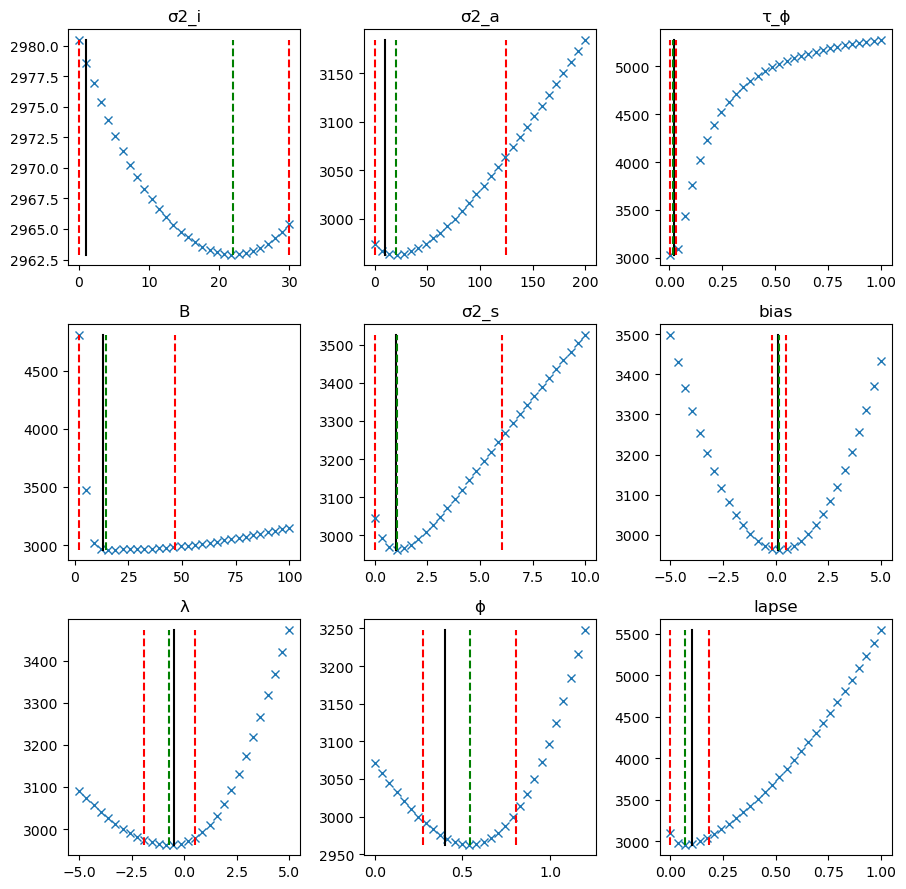

In [28]:
num_rows, num_cols = 3,3
fig, ax = subplots(num_rows, num_cols, figsize=(9,9))
name = ["σ2_i", "B", "λ", "σ2_a", "σ2_s", "ϕ", "τ_ϕ", "bias", "lapse"]

for i in 1:9
                  
    ax[i].plot(αs[i], LL_scan[i], "x")
    ax[i].set_title(name[i])
    ax[i].plot(xgen[i]*ones(100), range(minimum(LL_scan[i]), stop=maximum(LL_scan[i]), length=100), "k")
    ax[i].plot(xf[i]*ones(100), range(minimum(LL_scan[i]), stop=maximum(LL_scan[i]), length=100),
        "g--")
    ax[i].plot(max((xf[i] - CI[i]), lb[i]) *ones(100), range(minimum(LL_scan[i]), 
            stop=maximum(LL_scan[i]), length=100), "r--")
    ax[i].plot(min((xf[i] + CI[i]), ub[i]) *ones(100), range(minimum(LL_scan[i]), 
            stop=maximum(LL_scan[i]), length=100), "r--")

    
end

tight_layout() 
display(gcf())